# AIFFEL_1st_Hackathon :: 8조 baseline.v1
---

## 데이터 살펴보기
---

### 데이터 불러오기

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autotime

time: 199 µs (started: 2021-02-10 01:07:15 +09:00)


In [2]:
import tensorflow as tf

def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs
time: 1.88 s (started: 2021-02-10 01:07:15 +09:00)


In [3]:
!pwd

/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E10_kaggle/AIFFEL_1st_Hackathon/2.code
time: 114 ms (started: 2021-02-10 01:07:17 +09:00)


In [4]:
# workspace_dir을 pwd에서 확인한 본인의 주소로 바꿔주세요
workspace_dir = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E10_kaggle/AIFFEL_1st_Hackathon'

time: 404 µs (started: 2021-02-10 01:07:17 +09:00)


In [5]:
data_dir = workspace_dir + '/1.data'
code_dir = workspace_dir + '/2.code'
submission_dir = workspace_dir + '/3.submission'

train_data_path = join(data_dir, 'sales_train.csv')
test_data_path = join(data_dir, 'test.csv')
sample_submission_data_path = join(data_dir,'sample_submission.csv')
item_categories_data_path = join(data_dir, 'item_categories.csv')
items_data_path = join(data_dir, 'items.csv')
shops_data_path = join(data_dir, 'shops.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
sample_submission = pd.read_csv(sample_submission_data_path)
item_categories = pd.read_csv(item_categories_data_path)
items = pd.read_csv(items_data_path)
shops = pd.read_csv(shops_data_path)

item_categories_with_eng_name_data_path = join(data_dir, 'item_category_with_eng_name.csv')
item_categories_eng = pd.read_csv(item_categories_with_eng_name_data_path)

print('train data dim : {}'.format(train.shape)) # 훈련 데이터 형태
print('test data dim : {}'.format(test.shape))    # 시험 데이터 형태
print('submission dim : {}'.format(sample_submission.shape)) # 제출 샘플 데이터 형태
print('item_categories data dim : {}'.format(item_categories.shape)) # 아이템 카데고리 데이터 형태
print('items data dim : {}'.format(items.shape)) # 아이템 데이터 형태
print('shops data dim : {}'.format(shops.shape)) # 상점 데이터 형태

train data dim : (2935849, 6)
test data dim : (214200, 3)
submission dim : (214200, 2)
item_categories data dim : (84, 2)
items data dim : (22170, 3)
shops data dim : (60, 2)
time: 1.05 s (started: 2021-02-10 01:07:17 +09:00)


### 데이터 살펴보기

✊ 차후 EDA 문서와 통합

In [6]:
test = pd.read_csv(test_data_path)


time: 32.5 ms (started: 2021-02-10 01:07:18 +09:00)


## 전처리
---

### 결측치 탐색

#### train
- train 데이터의 결측치를 확인하고, 그에 대한 처리를 진행한다.

In [7]:
np.sum(pd.isnull(train))

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

time: 127 ms (started: 2021-02-10 01:07:18 +09:00)


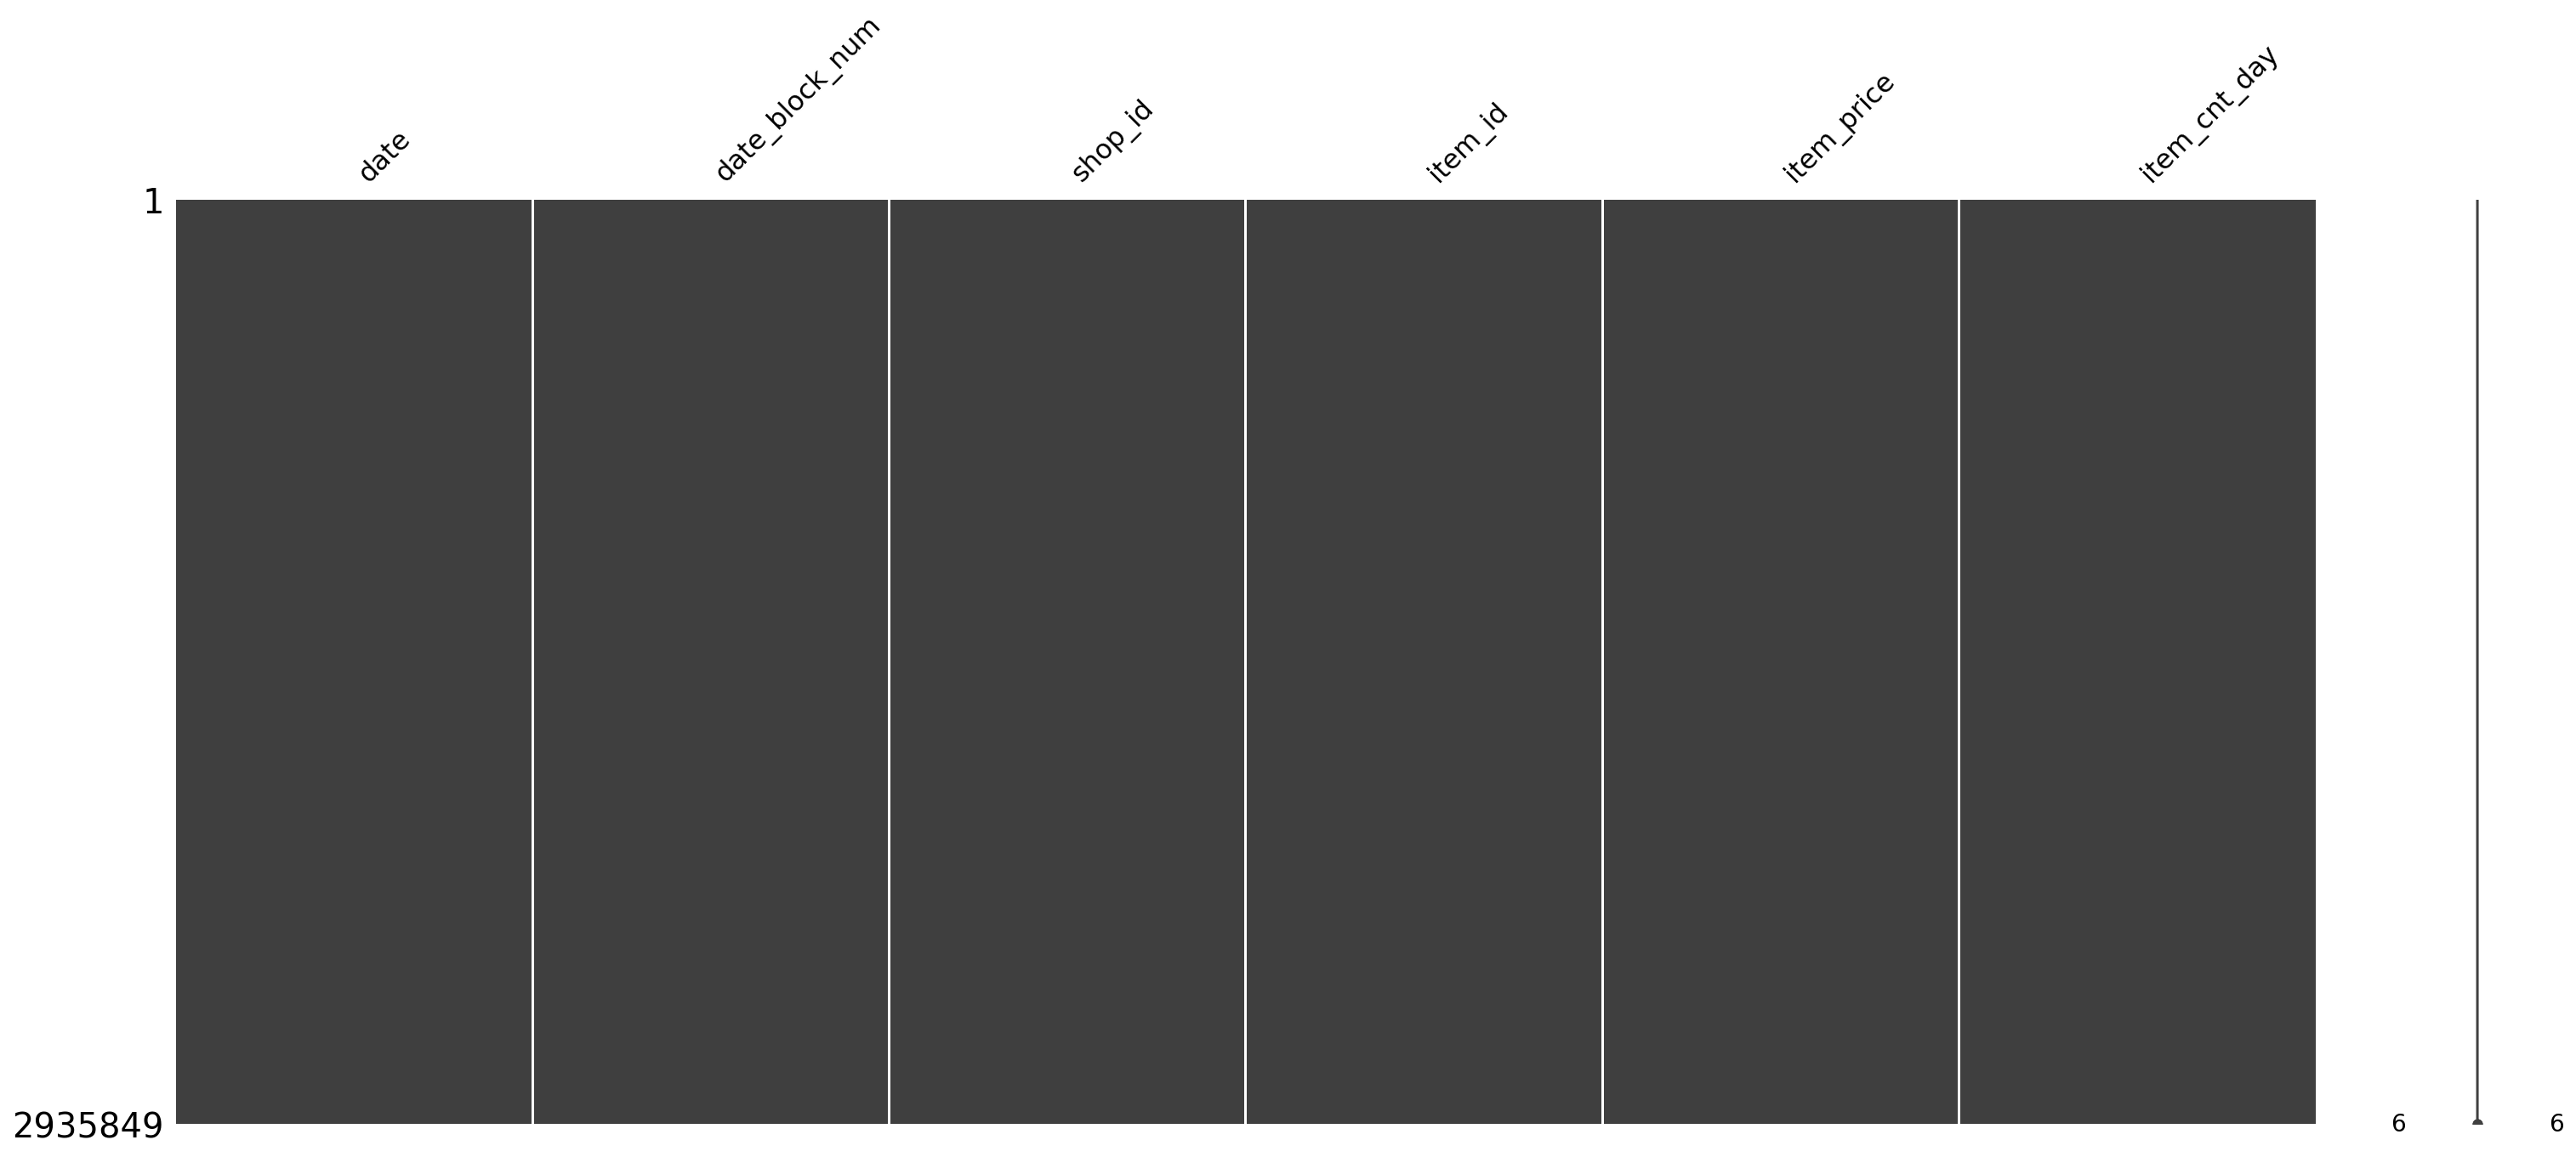

time: 4 s (started: 2021-02-10 01:07:19 +09:00)


In [8]:
msno.matrix(train)

- train 데이터에서는 결측치가 확인되지 않았다.

#### test

In [9]:
np.sum(pd.isnull(test))

ID         0
shop_id    0
item_id    0
dtype: int64

time: 4.11 ms (started: 2021-02-10 01:07:23 +09:00)


- test 데이터에서도 결측치가 확인되지 않았다.

In [10]:
train_ori = train.copy()

time: 49.8 ms (started: 2021-02-10 01:07:23 +09:00)


### 이상치 변경

- 너무 높은 `item_price`를 가진 데이터 제거

In [11]:
high_price_row = train[train['item_price'] > 100000]
high_price_row

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


time: 15.8 ms (started: 2021-02-10 01:07:23 +09:00)


In [12]:
train_outlier_removed = train.drop(high_price_row.index)
train_outlier_removed[train_outlier_removed['item_price'] > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


time: 148 ms (started: 2021-02-10 01:07:23 +09:00)


- `item_price`가 음수인 데이터 제거

In [13]:
minor_price_row = train_outlier_removed[train_outlier_removed['item_price'] < 0]
minor_price_row

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


time: 9.88 ms (started: 2021-02-10 01:07:23 +09:00)


In [14]:
train_outlier_removed = train_outlier_removed.drop(minor_price_row.index)
train_outlier_removed[train_outlier_removed['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


time: 239 ms (started: 2021-02-10 01:07:23 +09:00)


- 너무 높은 `item_cnt_day`를 가지는 데이터 제거

In [15]:
high_cnt_row = train_outlier_removed[train_outlier_removed['item_cnt_day'] > 1000]
high_cnt_row

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


time: 11 ms (started: 2021-02-10 01:07:23 +09:00)


In [16]:
train_outlier_removed = train_outlier_removed.drop(high_cnt_row.index)
train_outlier_removed[train_outlier_removed['item_cnt_day'] > 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


time: 246 ms (started: 2021-02-10 01:07:23 +09:00)


### 불필요한 Column 제거

- train 데이터에서 `date`를 제거한다.

In [17]:
train_remove_column = train_outlier_removed.drop(['date'], axis=1)
train_remove_column

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1.0
1,0,25,2552,899.00,1.0
2,0,25,2552,899.00,-1.0
3,0,25,2554,1709.05,1.0
4,0,25,2555,1099.00,1.0
...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0
2935845,33,25,7460,299.00,1.0
2935846,33,25,7459,349.00,1.0
2935847,33,25,7440,299.00,1.0


time: 29.2 ms (started: 2021-02-10 01:07:23 +09:00)


### 필요한 Column 추가

In [18]:
train_add_column = pd.merge(train_remove_column, items, left_on='item_id', right_on='item_id', how='left')
train_add_column = train_add_column.drop(['item_name'], axis=1)
train_add_column.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56
5,0,25,2564,349.00,1.0,59
6,0,25,2565,549.00,1.0,56
7,0,25,2572,239.00,1.0,55
8,0,25,2572,299.00,1.0,55
9,0,25,2573,299.00,3.0,55


time: 505 ms (started: 2021-02-10 01:07:23 +09:00)


In [19]:
np.sum(pd.isnull(train_add_column))

date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

time: 46.5 ms (started: 2021-02-10 01:07:24 +09:00)


### train 데이터 그룹화

In [20]:
train_add_column

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56
...,...,...,...,...,...,...
2935841,33,25,7409,299.00,1.0,55
2935842,33,25,7460,299.00,1.0,55
2935843,33,25,7459,349.00,1.0,55
2935844,33,25,7440,299.00,1.0,57


time: 12.3 ms (started: 2021-02-10 01:07:24 +09:00)


### train 데이터 분포 확인

- date_block_num, shop_id, item_id를 기준으로 item_cnt_day를 더한 데이터프레임 a와 date_block_num, shop_id, item_id를 기준으로 item_price를 평균낸 데이터프레임 b를 합하여 새로운 train 데이터를 생성한다.

In [21]:
a = train_add_column.groupby(['date_block_num','shop_id','item_id']).sum().reset_index()
a.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,884.0,6.0,160
1,0,0,33,1041.0,3.0,111
2,0,0,35,247.0,1.0,40
3,0,0,43,221.0,1.0,40
4,0,0,51,257.0,2.0,114


time: 660 ms (started: 2021-02-10 01:07:24 +09:00)


In [22]:
b = train_add_column.groupby(['date_block_num','shop_id','item_id']).mean().reset_index()
b.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,221.0,1.5,40
1,0,0,33,347.0,1.0,37
2,0,0,35,247.0,1.0,40
3,0,0,43,221.0,1.0,40
4,0,0,51,128.5,1.0,57


time: 610 ms (started: 2021-02-10 01:07:25 +09:00)


In [23]:
train_merged = a.copy()
train_merged['item_price'] = b['item_price']
train_merged

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,221.0,6.0,160
1,0,0,33,347.0,3.0,111
2,0,0,35,247.0,1.0,40
3,0,0,43,221.0,1.0,40
4,0,0,51,128.5,2.0,114
...,...,...,...,...,...,...
1609118,33,59,22087,119.0,6.0,249
1609119,33,59,22088,119.0,2.0,166
1609120,33,59,22091,179.0,1.0,83
1609121,33,59,22100,629.0,1.0,42


time: 33.5 ms (started: 2021-02-10 01:07:25 +09:00)


In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train_merged.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,1609123.00,1609123.00,1609123.00,1609123.00,1609123.00,1609123.00
mean,14.66,32.81,10680.99,790.69,2.27,72.98
std,9.54,16.54,6238.88,1532.59,8.47,93.31
min,0.00,0.00,0.00,0.09,-22.00,0.00
25%,6.00,21.00,5045.00,199.00,1.00,38.00
50%,14.00,31.00,10497.00,399.00,1.00,55.00
75%,23.00,47.00,16060.00,898.50,2.00,74.00
max,33.00,59.00,22169.00,50999.00,1644.00,2449.00


time: 286 ms (started: 2021-02-10 01:07:25 +09:00)


In [25]:
train_merged[train_merged['item_cnt_day'] == 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
4147,0,2,5643,2387.61,0.00,4
5609,0,4,7218,1594.00,0.00,38
6558,0,6,3676,2199.00,0.00,46
6566,0,6,3778,899.00,0.00,116
6753,0,6,5753,3490.00,0.00,150
...,...,...,...,...,...,...
1604609,33,52,18187,299.00,0.00,114
1605819,33,56,1538,999.00,0.00,38
1605876,33,56,3237,1998.00,0.00,40
1606537,33,56,19858,249.00,0.00,80


time: 18.1 ms (started: 2021-02-10 01:07:26 +09:00)


In [26]:
train_merged[train_merged['item_cnt_day'] < 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
5821,0,4,12211,1399.00,-1.00,62
7326,0,6,12283,1999.00,-1.00,62
11045,0,12,1590,2599.00,-13.00,116
11046,0,12,1592,3999.00,-1.00,23
11047,0,12,1593,1799.00,-6.00,87
...,...,...,...,...,...,...
1590963,33,26,10513,1499.00,-1.00,38
1591278,33,26,21363,3199.00,-1.00,41
1595028,33,34,7233,599.00,-1.00,3
1602434,33,48,2860,1799.00,-1.00,25


time: 15.7 ms (started: 2021-02-10 01:07:26 +09:00)


### train 데이터 분포 확인

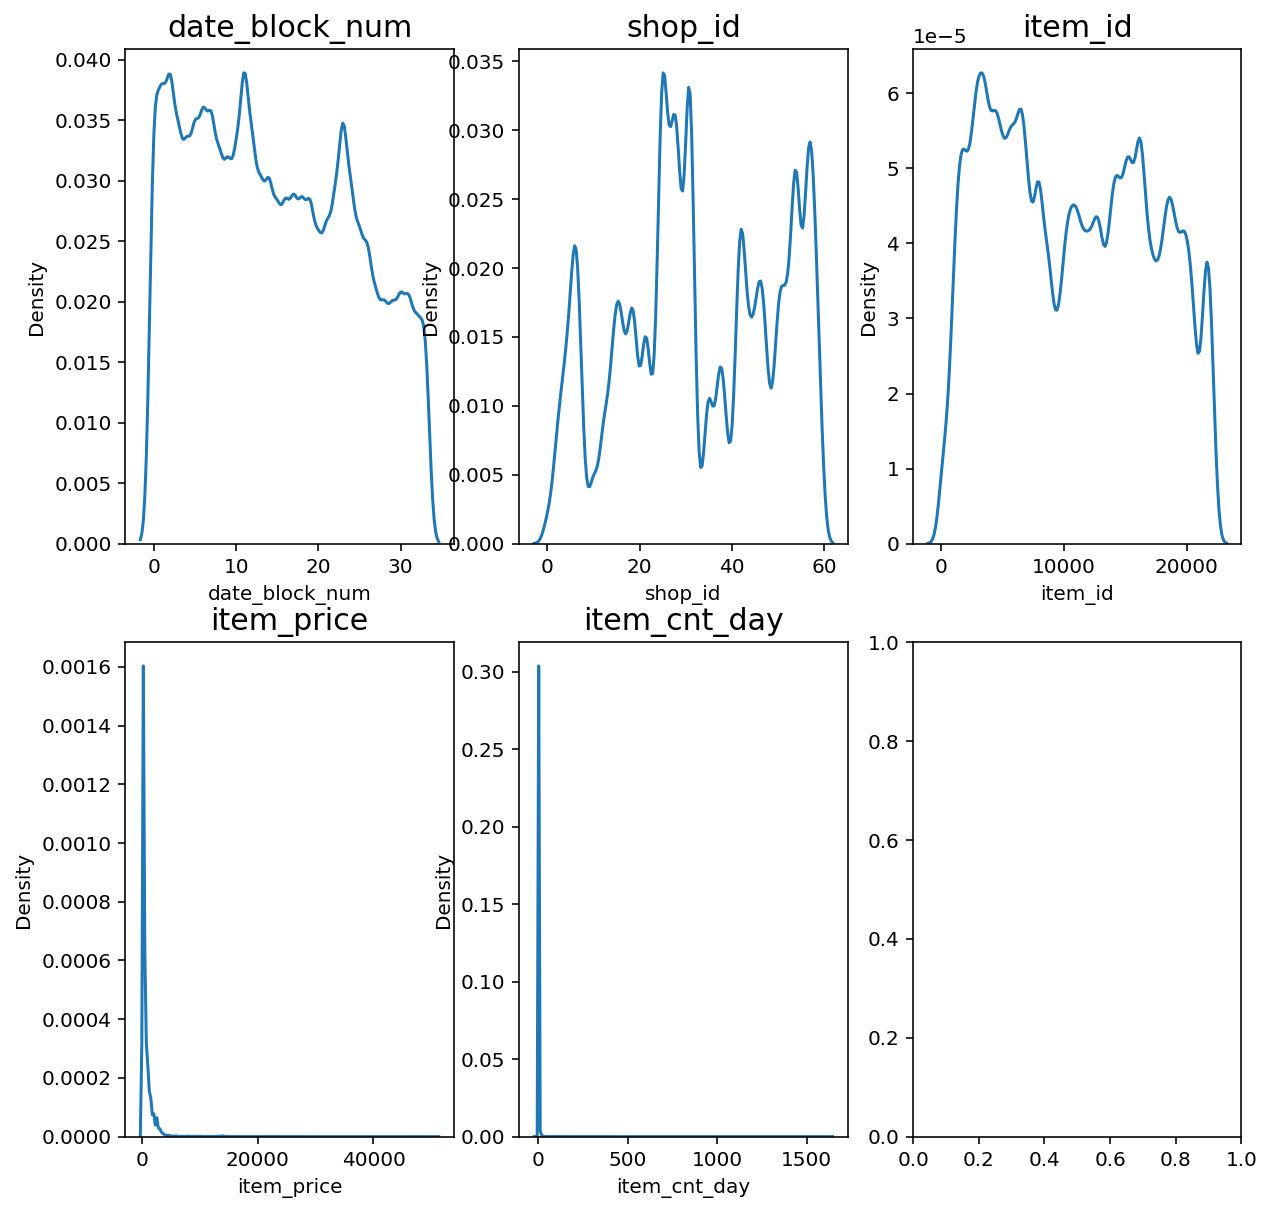

time: 27.3 s (started: 2021-02-10 01:07:26 +09:00)


In [27]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10)) 

count = 0
columns = train_merged.columns
for row in range(2):
    for col in range(3):
        sns.kdeplot(train_merged[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 5 :
            break

- `item_cnt_day` 데이터가 한 쪽으로 치우쳐진 경향을 보이고 있다.
- `item_cnt_day`에 대하여 log-scaling을 진행하여 데이터의 분포를 고르게 변화시켜 준다.

In [28]:
train_merged_log = train_merged.copy()
train_merged_log

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,221.00,6.00,160
1,0,0,33,347.00,3.00,111
2,0,0,35,247.00,1.00,40
3,0,0,43,221.00,1.00,40
4,0,0,51,128.50,2.00,114
...,...,...,...,...,...,...
1609118,33,59,22087,119.00,6.00,249
1609119,33,59,22088,119.00,2.00,166
1609120,33,59,22091,179.00,1.00,83
1609121,33,59,22100,629.00,1.00,42


time: 18.3 ms (started: 2021-02-10 01:07:53 +09:00)


In [29]:
def safe_log1p(x):
    return np.array([ np.log1p(i) if i > 0 else 0 for i in x])

time: 535 µs (started: 2021-02-10 01:07:53 +09:00)


In [30]:
train_merged_log = train_merged.copy()
train_merged_log['item_cnt_day'] = safe_log1p(train_merged_log['item_cnt_day'].values)

time: 2.35 s (started: 2021-02-10 01:07:53 +09:00)


In [31]:
train_merged_log['item_price'] = safe_log1p(train_merged_log['item_price'].values)

time: 2.4 s (started: 2021-02-10 01:07:55 +09:00)


In [32]:
train_merged_log

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,0,32,5.40,1.95,160
1,0,0,33,5.85,1.39,111
2,0,0,35,5.51,0.69,40
3,0,0,43,5.40,0.69,40
4,0,0,51,4.86,1.10,114
...,...,...,...,...,...,...
1609118,33,59,22087,4.79,1.95,249
1609119,33,59,22088,4.79,1.10,166
1609120,33,59,22091,5.19,0.69,83
1609121,33,59,22100,6.45,0.69,42


time: 10.9 ms (started: 2021-02-10 01:07:58 +09:00)


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


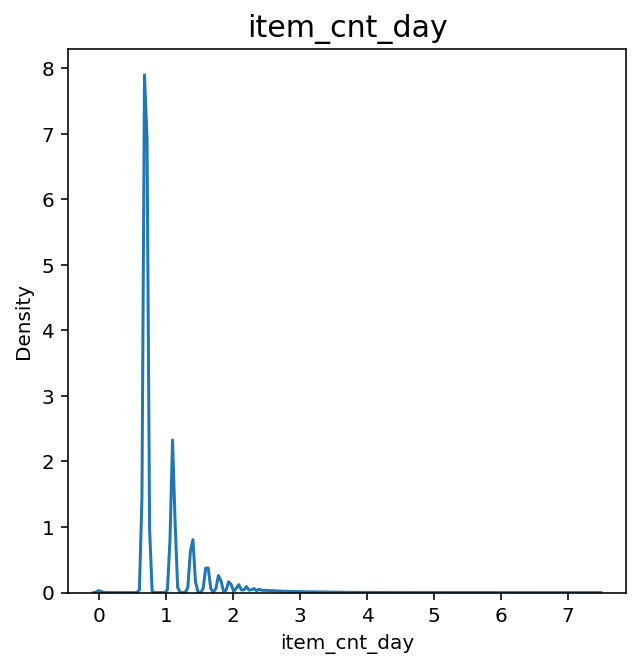

time: 4.85 s (started: 2021-02-10 01:07:58 +09:00)


In [33]:
fig, ax = plt.subplots(1, figsize=(5, 5)) 
sns.kdeplot(train_merged_log['item_cnt_day'], ax=ax)
ax.set_title('item_cnt_day', fontsize=15)
fig.show()

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


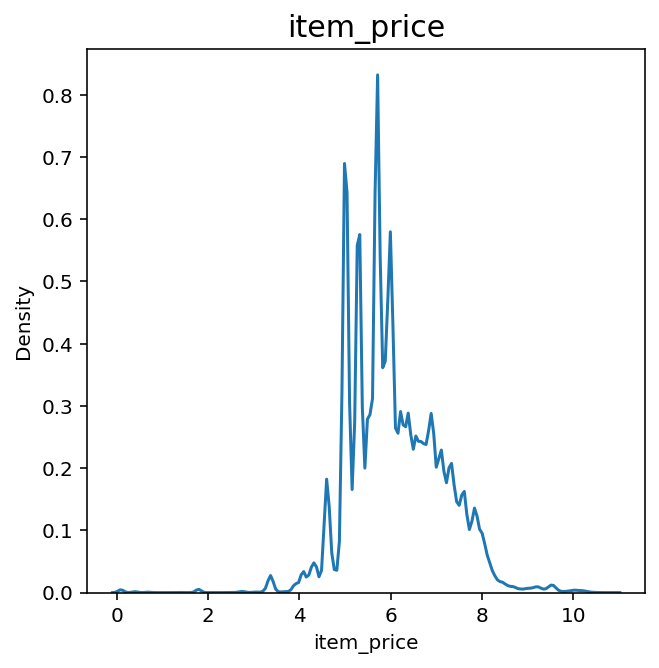

time: 5.25 s (started: 2021-02-10 01:09:43 +09:00)


In [46]:
fig, ax = plt.subplots(1, figsize=(5, 5)) 
sns.kdeplot(train_merged_log['item_price'], ax=ax)
ax.set_title('item_price', fontsize=15)
fig.show()

### train 데이터 분리

In [35]:
y = train_merged_log['item_cnt_day']
x_train = train_merged_log.drop(['item_cnt_day'], axis=1)

print(x_train.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_category_id'],
      dtype='object')
time: 20.7 ms (started: 2021-02-10 01:08:07 +09:00)


In [36]:
x_train

,date_block_num,shop_id,item_id,item_price,item_category_id
0,0,0,32,5.40,160
1,0,0,33,5.85,111
2,0,0,35,5.51,40
3,0,0,43,5.40,40
4,0,0,51,4.86,114
...,...,...,...,...,...
1609118,33,59,22087,4.79,249
1609119,33,59,22088,4.79,166
1609120,33,59,22091,5.19,83
1609121,33,59,22100,6.45,42


time: 43.7 ms (started: 2021-02-10 01:08:07 +09:00)


### Test 데이터 가공

#### Test column 추가/삭제

- test 데이터에 `date_block_num` column을 추가하고 모든 값은 34로 채운다.
- `item_category_id`를 추가한다.
- `ID`를 변수 `sub_id`에 저장하고, ID를 test에서 제거한다.

In [37]:
test_merge = test.copy()
test_merge["date_block_num"] = 34

sub_id = test_merge["ID"]
test_merge = test_merge.drop(['ID'], axis=1)

time: 6.17 ms (started: 2021-02-10 01:08:07 +09:00)


In [38]:
test_merge = pd.merge(test_merge, items, left_on='item_id', right_on='item_id', how='left')
test_merge = test_merge.drop(['item_name'], axis=1)

time: 30.7 ms (started: 2021-02-10 01:08:07 +09:00)


In [39]:
test_merge

,shop_id,item_id,date_block_num,item_category_id
0,5,5037,34,19
1,5,5320,34,55
2,5,5233,34,19
3,5,5232,34,23
4,5,5268,34,20
...,...,...,...,...
214195,45,18454,34,55
214196,45,16188,34,64
214197,45,15757,34,55
214198,45,19648,34,40


time: 6.41 ms (started: 2021-02-10 01:08:07 +09:00)


#### Test column 추가 - price

1. 같은 shop_id, item_id를 가지는 항목의 평균

In [40]:
price_candidate_1 = train_merged_log.groupby(['item_id', 'shop_id']).mean().reset_index()
price_candidate_1 = price_candidate_1.drop(['date_block_num', 'item_cnt_day','item_category_id'], axis=1)
price_candidate_1

,item_id,shop_id,item_price
0,0,54,4.08
1,1,55,8.41
2,2,54,4.08
3,3,54,4.35
4,4,54,4.08
...,...,...,...
424118,22168,12,6.68
424119,22168,16,6.68
424120,22168,42,6.68
424121,22168,43,6.68


time: 281 ms (started: 2021-02-10 01:08:07 +09:00)


In [41]:
test_1 = pd.merge(test_merge, price_candidate_1, on=['item_id','shop_id'], how='left')
test_1

,shop_id,item_id,date_block_num,item_category_id,item_price
0,5,5037,34,19,7.36
1,5,5320,34,55,nan
2,5,5233,34,19,6.72
3,5,5232,34,23,6.40
4,5,5268,34,20,nan
...,...,...,...,...,...
214195,45,18454,34,55,5.16
214196,45,16188,34,64,nan
214197,45,15757,34,55,5.30
214198,45,19648,34,40,nan


time: 67.9 ms (started: 2021-02-10 01:08:08 +09:00)


2. 같은 category 같은 shop_id의 평균

In [42]:
price_candidate_2 = train_merged_log.groupby(['item_category_id', 'shop_id']).mean().reset_index()
price_candidate_2 = price_candidate_2.drop(['date_block_num', 'item_id','item_cnt_day'], axis=1)
price_candidate_2

,item_category_id,shop_id,item_price
0,0,0,4.54
1,0,25,5.00
2,0,38,3.15
3,1,0,5.65
4,1,45,5.00
...,...,...,...
14651,2320,12,7.32
14652,2356,55,6.40
14653,2370,31,7.15
14654,2400,12,7.01


time: 123 ms (started: 2021-02-10 01:08:08 +09:00)


In [54]:
def update_price_2(x):
    if pd.isna(x['item_price']):
        search_res = price_candidate_2.loc[(price_candidate_2['item_category_id'] == x['item_category_id']) & 
                                (price_candidate_2['shop_id'] == x['shop_id'])].values
        if len(search_res) > 0: return search_res[0][2]
    return x['item_price']

time: 543 µs (started: 2021-02-10 01:12:40 +09:00)


In [55]:
test_2 = test_1.copy()
test_2['item_price'] = test_2.apply(update_price_2, axis=1)
test_2

,shop_id,item_id,date_block_num,item_category_id,item_price
0,5,5037,34,19,7.36
1,5,5320,34,55,5.61
2,5,5233,34,19,6.72
3,5,5232,34,23,6.40
4,5,5268,34,20,7.75
...,...,...,...,...,...
214195,45,18454,34,55,5.16
214196,45,16188,34,64,6.88
214197,45,15757,34,55,5.30
214198,45,19648,34,40,5.37


time: 1min 21s (started: 2021-02-10 01:12:41 +09:00)


In [45]:
np.sum(pd.isnull(test_2))

shop_id                 0
item_id                 0
date_block_num          0
item_category_id        0
item_price          17715
dtype: int64

time: 4.88 ms (started: 2021-02-10 01:09:43 +09:00)


In [56]:
test_1_nan_index = test_1['item_price'].isnull()
test_2[test_1_nan_index]

,shop_id,item_id,date_block_num,item_category_id,item_price
1,5,5320,34,55,5.61
4,5,5268,34,20,7.75
9,5,5003,34,20,7.75
16,5,4874,34,72,7.13
21,5,5002,34,19,7.06
...,...,...,...,...,...
214188,45,9500,34,40,5.37
214189,45,16007,34,64,6.88
214194,45,18027,34,70,5.91
214196,45,16188,34,64,6.88


time: 10.9 ms (started: 2021-02-10 01:14:23 +09:00)


3. 같은 category의 price 평균

In [47]:
price_candidate_3 = train_merged_log.groupby(['item_category_id']).mean().reset_index()
price_candidate_3 = price_candidate_3.drop(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], axis=1)
price_candidate_3

,item_category_id,item_price
0,0,4.23
1,1,5.33
2,2,7.60
3,3,7.26
4,4,7.10
...,...,...
690,2320,7.32
691,2356,6.40
692,2370,7.15
693,2400,7.01


time: 65.7 ms (started: 2021-02-10 01:10:21 +09:00)


In [58]:
def update_price_3(x):
    if pd.isna(x['item_price']):
        search_res = price_candidate_3.loc[(price_candidate_3['item_category_id'] == x['item_category_id'])].values
        if len(search_res) > 0: return search_res[0][1]
    return x['item_price']

time: 701 µs (started: 2021-02-10 01:15:25 +09:00)


In [59]:
test_3 = test_2.copy()
test_3['item_price'] = test_3.apply(update_price_3, axis=1)
test_3

,shop_id,item_id,date_block_num,item_category_id,item_price
0,5,5037,34,19,7.36
1,5,5320,34,55,5.61
2,5,5233,34,19,6.72
3,5,5232,34,23,6.40
4,5,5268,34,20,7.75
...,...,...,...,...,...
214195,45,18454,34,55,5.16
214196,45,16188,34,64,6.88
214197,45,15757,34,55,5.30
214198,45,19648,34,40,5.37


time: 14.3 s (started: 2021-02-10 01:15:26 +09:00)


In [60]:
np.sum(pd.isnull(test_3))

shop_id             0
item_id             0
date_block_num      0
item_category_id    0
item_price          0
dtype: int64

time: 5.84 ms (started: 2021-02-10 01:15:54 +09:00)


In [61]:
test_2_nan_index = test_2['item_price'].isnull()
test_3[test_2_nan_index]

,shop_id,item_id,date_block_num,item_category_id,item_price
200,5,6731,34,31,5.31
550,5,3022,34,31,5.31
612,5,1884,34,31,5.31
613,5,1885,34,31,5.31
683,5,3349,34,31,5.31
...,...,...,...,...,...
213824,45,3230,34,31,5.31
213825,45,3229,34,31,5.31
213826,45,3227,34,31,5.31
213835,45,2944,34,31,5.31


time: 9.67 ms (started: 2021-02-10 01:15:56 +09:00)


#### 정제된 테스트 데이터 저장

In [63]:
test_merged_path = join(data_dir, 'test_merged.csv')
test_3.to_csv(test_merged_path, index=False)
print(test_merged_path)

/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E10_kaggle/AIFFEL_1st_Hackathon/1.data/test_merged.csv
time: 539 ms (started: 2021-02-10 01:17:02 +09:00)


## 모델 선정 및 학습

In [ ]:
from sklearn.linear_model import LinearRegression # 일반 회귀 모델
from sklearn.linear_model import Ridge, Lasso, ElasticNet # norm 규제 회기 모델
from sklearn.linear_model import ARDRegression, BayesianRidge # 베이지안 회귀
from sklearn.ensemble import RandomForestRegressor # 앙상블 모델, bagging
from sklearn.ensemble import GradientBoostingRegressor # 앙상블 모델, boosting
import xgboost as xgb # 앙상블 모델, boosting
import lightgbm as lgb # 앙상블 모델, boosting

from sklearn.model_selection import GridSearchCV

In [ ]:
def get_hy_by_gride_search(model, param_grid, x_train, y, verbose=2, n_jobs=5, cv=5):
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=cv,
                              verbose=verbose,
                              n_jobs=n_jobs)

    grid_model.fit(x_train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    if verbose > 1 : display(results)
    
    params = { p : results[:1][p].values[0] for p in param_grid.keys() }
    
    return params, results[:1]['RMSLE'].values[0]

In [ ]:
def averaging_blending(x, y, sub_x, hps):
    for name, hp in hps.items() : 
        if name == 'LightGBM' :
            model = lgb.LGBMRegressor(max_depth=hp['max_depth'] ,
                                      n_estimators=hp['n_estimators']
                                      random_state=rs)
            model.fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    
    return np.mean(predictions, axis=1)

In [ ]:
def modeling(models, x_tain, y, test, verbose=2, n_jobs=5, cv=5):
    print(f'⭐ [modeling] start to find hyper params')
    
    hps = {}
    for model in models:
        print(f'⭐ [modeling] >>> {model["name"]}')
        params, PMSLE = get_hy_by_gride_search(model['model'], 
                                               model['param_grid'], 
                                               x_tain, 
                                               y, 
                                               verbose=verbose,
                                               n_jobs=n_jobs,
                                               cv=cv)
        hps[model["name"]] = { 'params' : params, 'PMSLE' : PMSLE }
    
    if verbose > 1 :
        print(f'⭐ [modeling] hyper param search end')
        print(hps)
        
    y_pred = averaging_blending(x_tain, y, test, hps)
    y_pred = np.expm1(y_pred)
    return y_pred

In [ ]:
params, RMSLE

In [ ]:
models = [
    {
        'name' : 'LightGBM',
        'model' :  lgb.LGBMRegressor(random_state=rs),
        'param_grid' : {
            'n_estimators': [50],
            'max_depth': [1, 10],
        }
    }
]
   
y_pred = modeling(models, x_train, y, test, verbose=1, n_jobs=1, cv=2)

In [ ]:
rs = 2021
gboost = GradientBoostingRegressor(random_state=rs)
xgboost = xgb.XGBRegressor(random_state=rs)
lightgbm = lgb.LGBMRegressor(random_state=rs)

models = [{'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

# models = [{'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation을 이용한 모델 성능평가

In [ ]:
def get_cv_score(models, n, random_state, x, y):
    kfold = KFold(n_splits=n,
                  random_state=random_state).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                   np.mean(cross_val_score(m['model'], x.values, y, cv=kfold)), 
                                                   ))

In [ ]:
get_cv_score(models, 5 , rs, x_train, y)

## Submittion

### 예측

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x_train, y, test)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
sub = pd.DataFrame(data={'ID': sub_id,'price':y_pred})
sub

### 평가

In [ ]:
# code ref : https://programmers.co.kr/learn/courses/21/lessons/945
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)

    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

### submission 파일 저장

In [ ]:
sample_submission['item_cnt_month'] = y_pred
sample_submission.head()

In [ ]:
submission_csv_path = join(submission_dir, 'baseline.csv')
sample_submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)